In [2]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import pandas as pd
from scipy.stats import expon

import os
import sys
sys.path.insert(0,'../src/')

from BayersianModel import BayersianModel
from Prior import Prior
from MCMC import NaiveSampler

In [3]:
n_cpus = max(os.cpu_count()//2,1)

$k_1 = 4, k_2 = 2, \#H = 10, \#H_2 = 10, T = 1 $

In [58]:
k1 = 4
k2 = 2
NH = 10
NH2 = 10
X_init = np.array((NH,NH2))
T = 1

# here are some other parameters that is unrelevant to gilespe
data_size = 5
k1_range = (1,7)
k2_range = (1,3)
theta = np.array((k1,k2))
parameter_range = np.array((k1_range,k2_range)).T

area = (k1_range[1]-k1_range[0])*(k2_range[1]-k2_range[0])

In [59]:
def parameters2str(theta=theta,X_init=X_init,T=T):
    sep = ', '
    return '   k1 = ' + str(theta[0]) + sep + 'k2 = ' + str(theta[1]) + sep + '#H = ' + str(X_init[0]) + sep + '#H2 = ' + str(X_init[1]) + sep + 'T = ' + str(T) + ' '

In [60]:
parameters2str()

'   k1 = 4, k2 = 2, #H = 10, #H2 = 10, T = 1 '

# the Gilespe simulation of hydrogens

it has done before, the parameters are

- $k_1$: binding reaction rate
- $k_2$: breaking reaction rate
- $N_H$: number of $H$
- $N_{H_2}$: number of $H_2$
- $T$: total time of simulation

and I am just going to copy my previous codes here

In [16]:
def product(a,b):
    '''
    this returns the product of
    b * (b-1) * (b-2) * ... * (b-a+1)
    '''
    
    if a == 0:
        return 1
    if b < a:
        return 0
    return np.product(np.arange(b-a+1,b+1,1))

In [17]:
# compounds should be a dictionary, key = name of the conpund, val = quantity of the counpound. 

class reaction:
    
    def __init__(self,input_compounds, output_compounds, reaction_rate, name=None):
        
        self.input = input_compounds
        self.output = output_compounds
        self.rr = reaction_rate
        self.name = name
    
    def proba(self,i):
        
        return self.rr * np.product([product(self.input[key],i[key]) for key in self.input])
    
class chemical_system:
    
    def __init__(self, chemicals, reactions):
        
        self.chemicals = deepcopy(chemicals)
        self.reactions = reactions
    
    def gillespie(self,t,T):
        
        # calculate probability
        A = [reaction.proba(self.chemicals) for reaction in self.reactions]
        a = sum(A)
                
        # sampling next time
        dt = np.random.exponential(1/sum(A))
        
        if t + dt > T:
            return None
        
        # sampling next action
        A = A/a
        action = np.random.choice(self.reactions,1,False,A)[0]
        
        # take the action. 
        for c in self.chemicals:
            self.chemicals[c] -= action.input[c]
            self.chemicals[c] += action.output[c]
            if self.chemicals[c] < 0:
                assert(False)
        
        return t + dt
        
    def simulation(self, T, record=False):
        
        chemicals = deepcopy(self.chemicals)
        
        t = 0
        
        if record:
            records = [[t] + list(self.chemicals.values())]
        
        while t != None:
            t = self.gillespie(t,T)
            if record and t != None:
                records.append([t] + list(self.chemicals.values()))
        
        # reset
        self.chemicals = chemicals

        if record:
            records = pd.DataFrame(data=records,columns=['time']+ list(self.chemicals.keys()))
            return records
        
           

In [18]:
chemicals = {
    "O_2": NH2,
    "O":   NH
    }

binding = reaction(
    input_compounds  = {'O':2, 'O_2':0},
    output_compounds = {'O':0, 'O_2':1},
    reaction_rate    = k1
)

breaking = reaction(
    input_compounds={'O':0, 'O_2':1},
    output_compounds={'O':2, 'O_2':0},
    reaction_rate = k2
)

reactions = [binding, breaking]


def init_chemical_system():
    return chemical_system(chemicals,reactions)

In [19]:
chem_sys = init_chemical_system()
records = chem_sys.simulation(T=T, record=True)

<AxesSubplot:xlabel='time'>

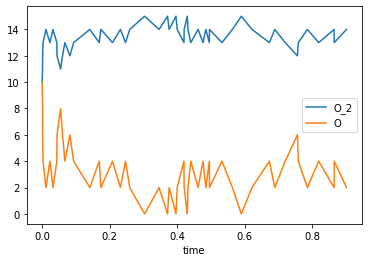

In [20]:
records.set_index('time').plot()

-----

the above shows that I can generate the gillespie samples. 

Now I can generate bunch of them for `observation` and write down the likelyhood, etc, for inference. 

## data gen and plotting

In [21]:
observation = [chem_sys.simulation(T=T,record=True).to_numpy() for i in range(data_size)]

In [22]:
[len(i) for i in observation] # this is the number of reactions happened for each simulation

[59, 61, 56, 59, 50]

## likelyhood

this tries to compute the likelyhood given
- parameter
- outcome

it is a log likelyhood

In [23]:
def log_likelyhood(theta, observation):
    
    '''
    theta: (k1,k2)
    observation: an n*3 array, where n is number of reactions, and 3 is for (t, O1, O2)
    '''
    
    ret = 0
    
    k1,k2 = theta
    
    binding = reaction(
        input_compounds  = {'O':2, 'O_2':0},
        output_compounds = {'O':0, 'O_2':1},
        reaction_rate    = k1)

    breaking = reaction(
        input_compounds={'O':0, 'O_2':1},
        output_compounds={'O':2, 'O_2':0},
        reaction_rate = k2)
    
    reactions = [binding,breaking]
    
    for sample in observation:
        
        prev_t, prev_n1, prev_n2 = sample[0]
        
        for t,n1,n2 in sample[1:]:
            # the probability of each step is depends on 
            # dt and binding or not. 
            
            reaction_rates = [reaction.proba({'O_2':prev_n1,'O':prev_n2}) 
                            for reaction in reactions]
            propensity = sum(reaction_rates)
            dt = t - prev_t
            p = reaction_rates[0]/propensity if n1>prev_n1 else\
                reaction_rates[1]/propensity
            
            ret += expon.logpdf(dt, scale=1/propensity) + np.log(p)
            
            prev_t, prev_n1, prev_n2 = t,n1,n2
    
    # ❓❕
    # do i need to calculate the probability density for nothing happening in the last few miliseconds? 
    # that would not be a pdf, but rather a p. 
    
    return ret    

assume the prior is just a uniform distribution of the square, let's construct the prior

In [24]:
prior = Prior(
    log_pdf = lambda _ : -np.log(area),
    sampler = lambda : (np.random.uniform(*k1_range),np.random.uniform(*k2_range)),
    theta_range = parameter_range
)

In [25]:
model = BayersianModel(
    prior = prior,
    observation = observation,
    log_likelyhood = log_likelyhood,
)

**cautious**, the following heat diagram generated with 2 minutes of time. don't re-compute it 

computing posterior: 100%|██████████| 10000/10000 [04:40<00:00, 35.62it/s]


<AxesSubplot:title={'center':'the pdf for posterior'}>

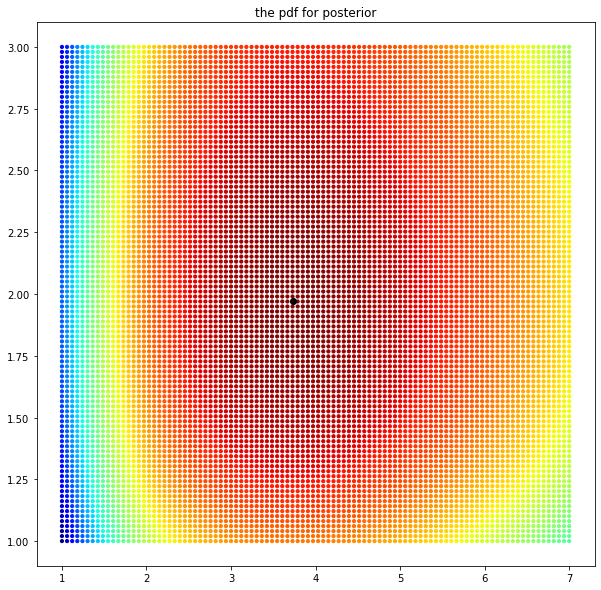

In [26]:
model.posterior_heatmap(n=(100,100),s=10)

$k_1 = 4, k_2 = 2, \#H = 10, \#H_2 = 10, T = 1 $

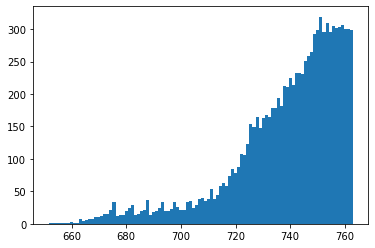

In [51]:
plt.hist(model.P[-1],bins=100)
print()

In [55]:
model.P[-1].max()

762.9236197486623

## inference

this inference is very slow because evaluating the log_posterior_proba is too expansive. 

In [27]:
mcmc = NaiveSampler(model=model)
posterior_samples = mcmc.simulation(theta_range='positive',box_size=0.5, n=int(1e5))

sampling posterior: 100%|██████████| 100100/100100 [46:28<00:00, 35.90it/s]

acceptance rate: 0.4064235764235764


## plot

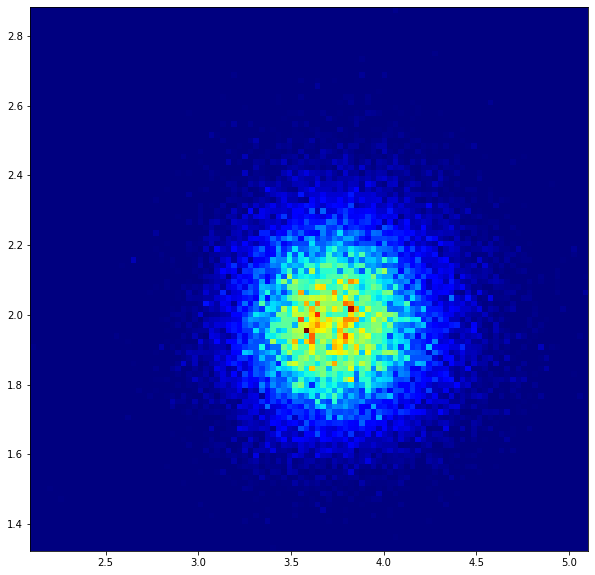

In [29]:
XX, YY = posterior_samples.T
plt.figure(figsize=(10,10))
plt.hist2d(XX,YY,bins=(100,100),cmap='jet')
print()

$k_1 = 4, k_2 = 2, \#H = 10, \#H_2 = 10, T = 1 $

In [37]:
from statsmodels.tsa.stattools import acf

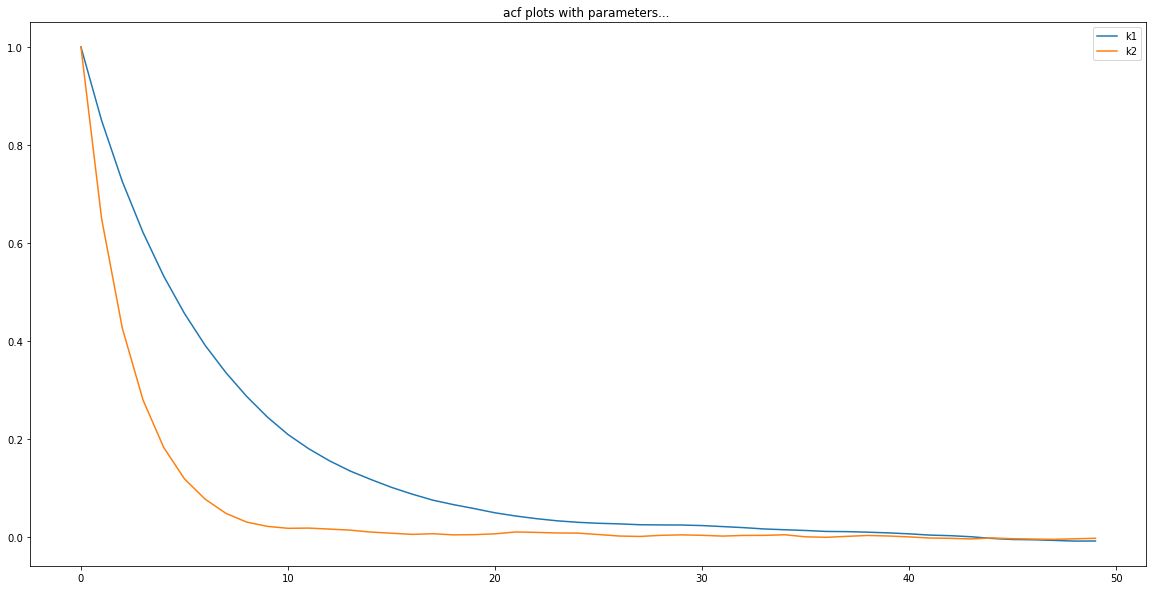

In [45]:
plt.figure(figsize=(20,10))
plt.plot(acf(XX,nlags=1000)[:50],label='k1')
plt.plot(acf(YY,nlags=1000)[:50],label='k2')
plt.title('acf plots with parameters... ')
plt.legend()

$\tau \le 10$, this sampler is actually pretty good, despite the terrible heatmap it generates 